In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split

In [34]:
dic = pickle.load(open('trainingDataSetSmallHSC_RC2.pkl', 'rb'))
data=pd.DataFrame(dic)

StarID=np.array(data.columns)
star= np.array(data.iloc[0])

dicc= dict(zip(StarID, star))

In [35]:
#Tener en cuenta que las imágenes ya están normalizadas
all_images= np.array(data.iloc[0])
# Convierte a un array NumPy 3D: (N, 25, 25)
all_images = np.stack(all_images)  
# Agrega canal para PyTorch: (N, 1, 25, 25)
all_images = np.expand_dims(all_images, axis=1)

In [36]:
piff = np.array(data.iloc[2])
piff=np.stack(piff)
piff=np.expand_dims(piff,axis=1)

In [37]:
print(all_images.shape)
print(all_images.dtype)
print(all_images.max(), all_images.min())

(20001, 1, 25, 25)
float32
0.5590923 -0.024684794


In [38]:
# Convierte los arreglos a tensores con tipo float32 para compatibilidad con PyTorch
tensor_images = torch.tensor(all_images, dtype=torch.float32)

# Dataset completo (usamos las imágenes como entrada y como objetivo)
dataset = TensorDataset(tensor_images, tensor_images)

# Define proporciones para entrenamiento y validación
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
val_size = len(dataset) - train_size  # 20% para validación

# Fijar la semilla
generator = torch.Generator().manual_seed(1)

# Divide el dataset aleatoriamente
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Crea DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #shuffle=True mezcla aleatoriamente los datos 
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


print(all_images.min(), all_images.max())

-0.024684794 0.5590923


In [39]:
# Encoder
class Encoder(nn.Module):  # Hereda de nn.Module, la base para todos los modelos en PyTorch
    ''' Clase define la parte codificadora del VAE. 
    Su función es tomar una imagen (25x25 píxeles) y producir una representación comprimida (latente) 
    en el espacio latente definido por mu (media) y logvar (log-varianza).'''
    def __init__(self, latent_dim):  # latent_dim es la dimensión del espacio latente
        super(Encoder, self).__init__()

        # Primera capa totalmente conectada (fully connected)
        # Entrada de tamaño 625 (porque 25x25 = 625 píxeles por imagen)
        # Salida: 256 neuronas
        self.fc1 = nn.Linear(625, 256)

        # Segunda capa: reduce a 128 neuronas
        self.fc2 = nn.Linear(256, 128)

        # Capa para calcular la media (μ) del vector latente
        self.fc_mu = nn.Linear(128, latent_dim)

        # Capa para calcular la log-varianza (log(σ²)) del vector latente
        self.fc_logvar = nn.Linear(128, latent_dim)



    def forward(self, x):
        x = x.view(-1, 625)  # Aplana cada imagen 25x25 a un vector de 625 elementos

        # Paso por la primera capa y se aplica la activación ReLU
        h1 = F.relu(self.fc1(x))

        # Paso por la segunda capa con ReLU nuevamente
        h2 = F.relu(self.fc2(h1))

        # Se generan los vectores de media y log-varianza desde la segunda capa
        mu = self.fc_mu(h2)         # Vector medio (μ) del espacio latente
        logvar = self.fc_logvar(h2) # Vector log-varianza (log(σ²)) del espacio latente

        # Se retorna la media y log-varianza, que luego se usan para la reparametrización
        return mu, logvar


# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 625)
        self.softmax = nn.Softmax(dim=1)  # Aplica softmax a lo largo del vector de 625 valores (dim=1)

    def forward(self, z):
        h1 = F.relu(self.fc1(z))               # (batch_size, 128)
        h2 = F.relu(self.fc2(h1))              # (batch_size, 256)
        x_flat = self.fc3(h2)                  # (batch_size, 625)
        x_flat = self.softmax(x_flat)          # (batch_size, 625) - normalizado (suma=1)
        return x_flat.view(-1, 1, 25, 25)       # (batch_size, 1, 25, 25)

    

# VAE Model
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder  # Red neuronal encargada de comprimir los datos de entrada al espacio latente
        self.decoder = decoder  # Red neuronal encargada de reconstruir los datos a partir del vector latente

    def reparameterize(self, mu, logvar):
        """
        Aplica el truco de reparametrización:
        En vez de muestrear directamente de una distribución (lo cual no es diferenciable),
        se transforma una variable aleatoria normal estándar para que tenga media mu y varianza logvar.
        Esto permite entrenar el modelo usando backpropagation.
        """
        std = torch.exp(0.5 * logvar)        # Calcula la desviación estándar a partir de la varianza logarítmica
        eps = torch.randn_like(std)          # Muestra ruido aleatorio de una normal estándar
        return mu + eps * std                # Retorna la muestra z usando la fórmula: z = mu + std * eps

    def forward(self, x):
        """
        Pasa los datos de entrada x por el modelo completo:
        1. Codifica x a mu y logvar.
        2. Aplica reparametrización para obtener z.
        3. Decodifica z para obtener x_hat (la reconstrucción).
        """
        mu, logvar = self.encoder(x)         # Codifica la entrada y obtiene los parámetros de la distribución latente
        z = self.reparameterize(mu, logvar)  # Aplica el truco de reparametrización para obtener el vector latente z
        x_hat = self.decoder(z) # Reconstruye la imagen a partir de z          
        return x_hat, mu, logvar             # Devuelve la imagen reconstruida y los parámetros del espacio latente


# VAE Loss function
def vae_loss(x_hat, x, mu, logvar):
    # ==========================
    # 1. Reconstrucción
    # ==========================
    # Calcula el error entre la imagen reconstruida (x_hat) y la imagen original (x)
    # Aquí se usa el error cuadrático medio (MSE), sumado en todos los píxeles
    # Si estás usando imágenes normalizadas entre 0 y 1, esto tiene sentido como métrica de calidad
    recon_loss = F.mse_loss(x_hat, x, reduction='mean')

    # ==========================
    # 2. Divergencia KL
    # ==========================
    # Esta parte penaliza que la distribución latente (mu, logvar) se aleje de una normal estándar (media 0, varianza 1)
    # Fórmula: D_KL(N(mu, sigma) || N(0, 1))
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # ==========================
    # 3. Pérdida total = reconstrucción + regularización
    # ==========================
    # La pérdida total busca:
    # - Que la reconstrucción sea buena (recon_loss pequeña)
    # - Que el espacio latente esté regulado (kl_div pequeña)
    return recon_loss + kl_div



In [40]:
# Configuración
latent_dim = 2
device = torch.device("cpu")

# Inicializar modelo, optimizador
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(latent_dim).to(device)
vae = VAE(encoder, decoder).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-6)

num_epochs = 80
train_loss_per_epoch = []
val_loss_per_epoch = []

# Entrenamiento
for epoch in range(num_epochs):
    vae.train()
    total_train_loss = 0

    for x_batch, _ in train_loader:
        x_batch = x_batch.to(device)
        optimizer.zero_grad()

        x_hat, mu, logvar = vae(x_batch)
        loss = vae_loss(x_hat, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_per_epoch.append(avg_train_loss)

    # Evaluación
    vae.eval()
    total_val_loss = 0

    with torch.no_grad():
        for x_val, _ in val_loader:
            x_val = x_val.to(device)
            x_hat_val, mu_val, logvar_val = vae(x_val)
            val_loss = vae_loss(x_hat_val, x_val, mu_val, logvar_val)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_per_epoch.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.15f}, Val Loss: {avg_val_loss:.15f}")


Epoch 1, Train Loss: 0.189780, Val Loss: 0.176353
Epoch 2, Train Loss: 0.166516, Val Loss: 0.154455
Epoch 3, Train Loss: 0.145540, Val Loss: 0.134632
Epoch 4, Train Loss: 0.126402, Val Loss: 0.116412
Epoch 5, Train Loss: 0.108785, Val Loss: 0.099693
Epoch 6, Train Loss: 0.092740, Val Loss: 0.084560
Epoch 7, Train Loss: 0.078204, Val Loss: 0.070819
Epoch 8, Train Loss: 0.065070, Val Loss: 0.058547
Epoch 9, Train Loss: 0.053442, Val Loss: 0.047681
Epoch 10, Train Loss: 0.043099, Val Loss: 0.038012
Epoch 11, Train Loss: 0.033950, Val Loss: 0.029556
Epoch 12, Train Loss: 0.026081, Val Loss: 0.022368
Epoch 13, Train Loss: 0.019391, Val Loss: 0.016281
Epoch 14, Train Loss: 0.013817, Val Loss: 0.011302
Epoch 15, Train Loss: 0.009326, Val Loss: 0.007365
Epoch 16, Train Loss: 0.005862, Val Loss: 0.004421
Epoch 17, Train Loss: 0.003363, Val Loss: 0.002393
Epoch 18, Train Loss: 0.001731, Val Loss: 0.001155
Epoch 19, Train Loss: 0.000793, Val Loss: 0.000496
Epoch 20, Train Loss: 0.000327, Val Loss

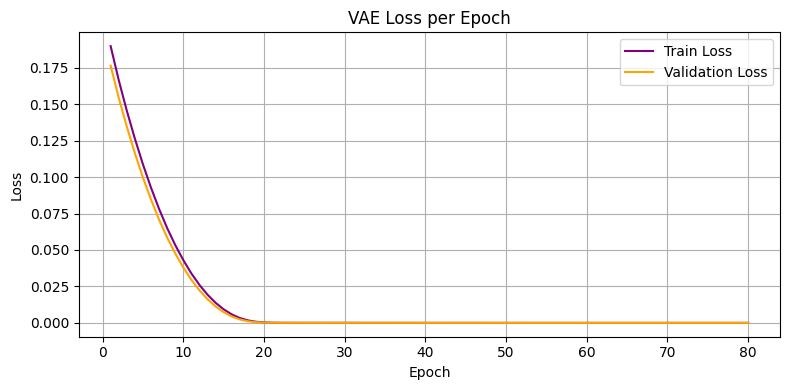

In [41]:
# Graficar pérdida de entrenamiento y validación por época
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_loss_per_epoch) + 1), train_loss_per_epoch, label="Train Loss", color='purple')
plt.plot(range(1, len(val_loss_per_epoch) + 1), val_loss_per_epoch, label="Validation Loss", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Loss per Epoch")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


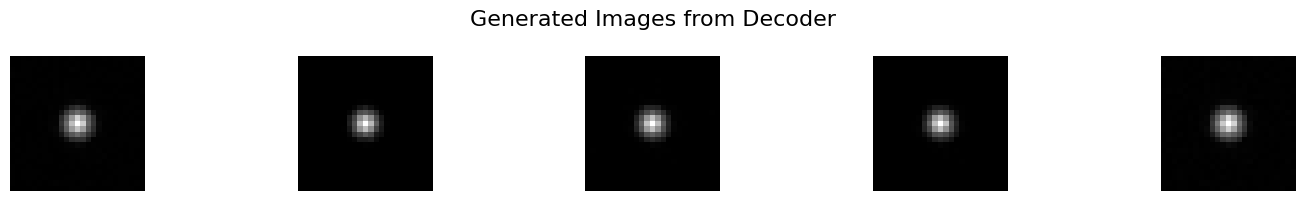

In [42]:
# Pone el modelo en modo evaluación
vae.eval()

# Bloque donde no se calculan gradientes 
with torch.no_grad():
    # Creamos 10 vectores aleatorios en el espacio latente, tamaño (10, latent_dim)
    # Esto simula "ideas" de imágenes codificadas
    z = torch.randn(10, latent_dim).to(device)

    # Pasamos los vectores aleatorios por el decoder para generar imágenes
    generated_images = vae.decoder(z).cpu()  # lo pasamos a CPU para visualizar

    # Aseguramos que los valores de píxeles estén entre 0 y 1
    #generated_images = torch.clamp(generated_images, 0.0, 1.0)

# Visualizamos algunas de las imágenes generadas
n = 5  # Número de imágenes que queremos mostrar
plt.figure(figsize=(15, 2))  # Tamaño de la figura general

for i in range(n):
    ax = plt.subplot(1, n, i + 1)  # Creamos una subfigura (1 fila, n columnas)
    
    # Mostramos la i-ésima imagen, accediendo al canal [0] porque son grises (1 canal)
    plt.imshow(generated_images[i, 0], cmap="gray")
    
    # Ocultamos ejes
    plt.axis("off")

# Título general de la figura
plt.suptitle("Generated Images from Decoder", fontsize=16)

# Ajusta el espaciado entre las imágenes
plt.tight_layout()

# Muestra el gráfico
plt.show()





MSE entre entradas y reconstrucciones: 0.000007549460406


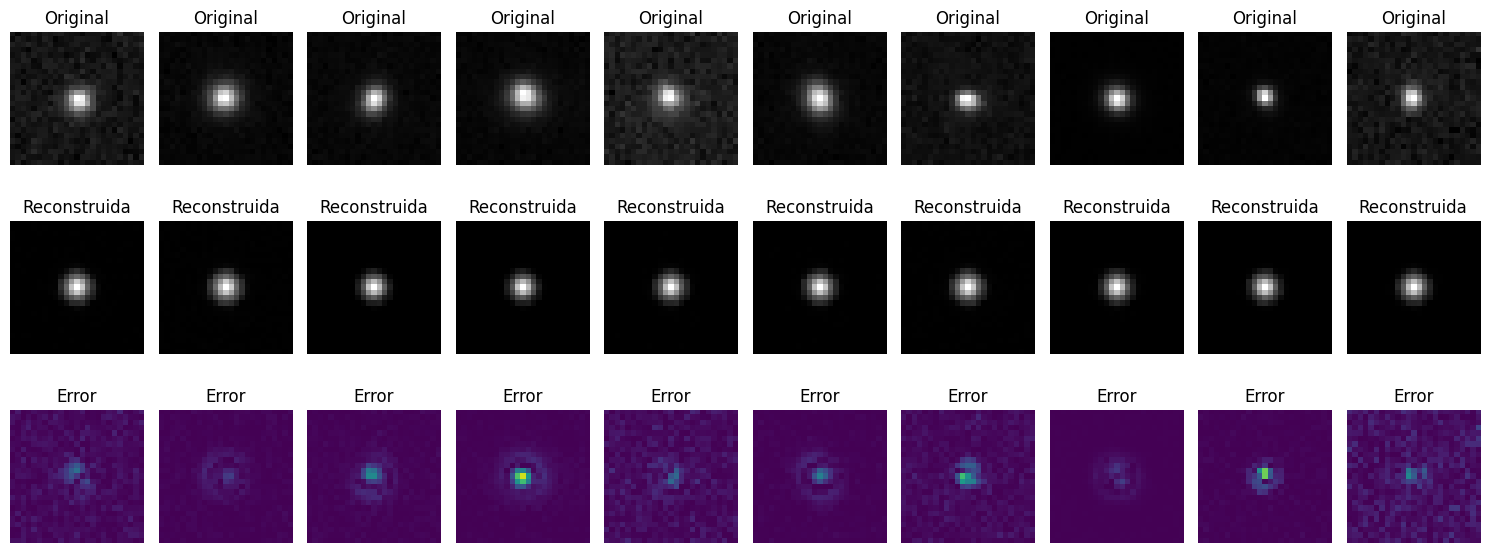

In [43]:
# Ponemos el VAE en modo evaluación
vae.eval()

# Tomamos un batch del conjunto de validación
x_val_batch, _ = next(iter(val_loader))
x_val_batch = x_val_batch.to(device)

with torch.no_grad():
    # Pasamos las imágenes por el encoder y el decoder
    x_hat, _, _ = vae(x_val_batch)

# Calculamos el error absoluto
errors = torch.abs(x_val_batch - x_hat)

# Calculamos el error cuadrático medio (MSE)
MSE = nn.MSELoss()(x_hat, x_val_batch).item()
print(f"MSE entre entradas y reconstrucciones: {MSE:.15f}")

# Visualizamos imágenes originales, reconstruidas y su error
n = 10  # Número de imágenes a mostrar
plt.figure(figsize=(15, 6))

for i in range(n):
    # Imagen original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val_batch[i, 0].cpu(), cmap="gray")
    ax.set_title("Original")
    plt.axis("off")

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_hat[i, 0].cpu(), cmap="gray")
    ax.set_title("Reconstruida")
    plt.axis("off")

    # Error absoluto
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(errors[i, 0].cpu(), cmap="viridis", vmax=0.05)
    ax.set_title("Error")
    plt.axis("off")

plt.tight_layout()
plt.show()


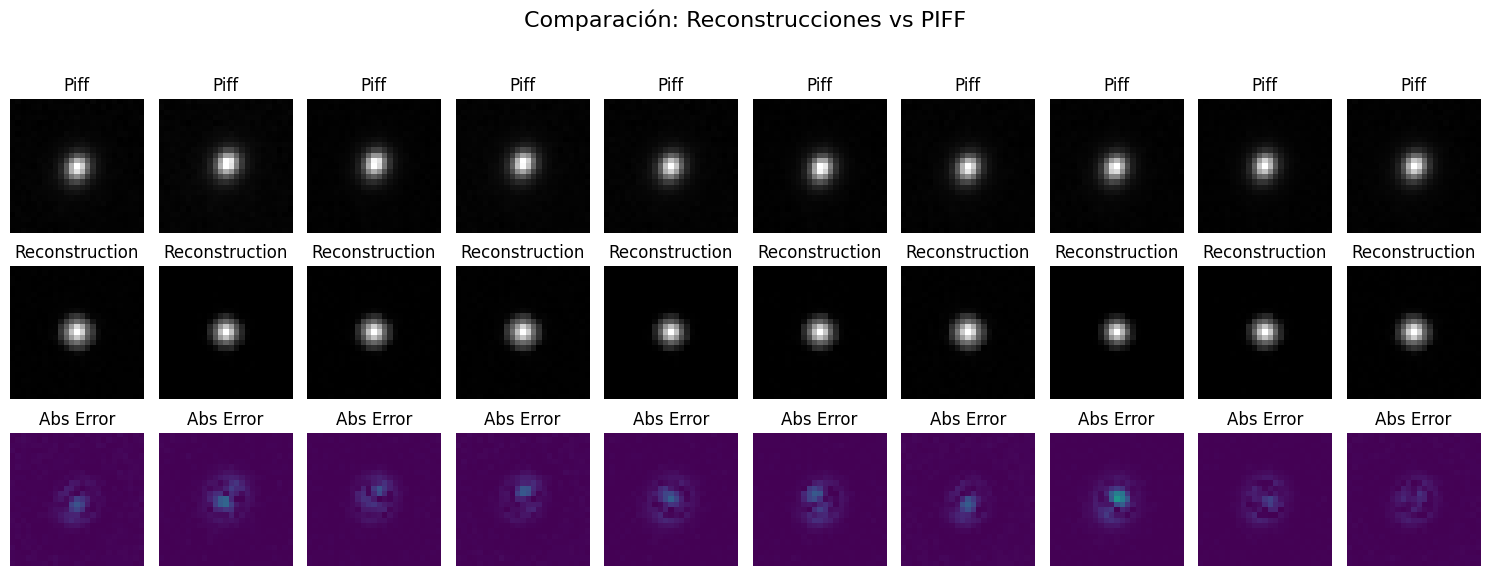

MSE entre reconstrucciones y PIFF: 0.000007535276836


In [44]:
# Poner el modelo en modo evaluación
vae.eval()

# Loaders sin shuffle para mantener el orden
train_loader = DataLoader(all_images, batch_size=32, shuffle=False) 
piff_loader  = DataLoader(piff, batch_size=32, shuffle=False)

all_errors = []
all_inputs = []
all_reconstructions = []
all_piffs = []

with torch.no_grad():
    for x_val_batch, x_piff_batch in zip(train_loader, piff_loader):
        x_val_batch = x_val_batch.to(device)
        x_piff_batch = x_piff_batch.to(device)

        # Reconstrucción
        x_hat, _, _ = vae(x_val_batch)  # Si tu VAE devuelve solo x_hat, cambia esta línea

        # Guardar datos
        errors = torch.abs(x_piff_batch - x_hat)
        all_errors.append(errors.cpu())
        all_inputs.append(x_val_batch.cpu())
        all_reconstructions.append(x_hat.cpu())
        all_piffs.append(x_piff_batch.cpu())

# Concatenar todos los batches
all_errors = torch.cat(all_errors)
all_inputs = torch.cat(all_inputs)
all_reconstructions = torch.cat(all_reconstructions)
all_piffs = torch.cat(all_piffs)

# Mostrar las primeras N imágenes
n = 10
plt.figure(figsize=(15, 6))  # Ajuste de tamaño para que se vea mejor

for i in range(n):
    # Imagen PIFF (referencia)
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(all_piffs[i, 0], cmap="gray")
    ax.set_title("Piff")
    plt.axis("off")

    # Imagen reconstruida
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(all_reconstructions[i, 0], cmap="gray")
    ax.set_title("Reconstruction")
    plt.axis("off")

    # Error absoluto
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(all_errors[i, 0], cmap="viridis", vmax=0.05)
    ax.set_title("Abs Error")
    plt.axis("off")

# Título general de la figura
plt.suptitle("Comparación: Reconstrucciones vs PIFF", fontsize=16)

# Ajustar el espaciado entre filas e imagen superior
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Mostrar la figura
plt.show()

# Calcular el MSE total entre reconstrucciones y piff
MSE = nn.MSELoss()(all_reconstructions, all_piffs).item()
print(f"MSE entre reconstrucciones y PIFF: {MSE:.15f}")
